<a href="https://colab.research.google.com/github/rahulkhawashi/Dog-breed-vision/blob/main/dog_visionproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End-to-end Multi-class Dog Breed Classification

This notebook builds an end-to-end multi-class image classifier using Tensorflow 2.0 and TensorFlow Hub.

## 1. problem
Identifying the breed of a dog given an image of a dog.

When I'm sitting at the cafe and I take a photo a dog, I want to know what breed of dog it is.

## 2. Data
The data we're using is from kaggle's Dog Breed Identification Competition.

## 3. Evaluation
The village needs a file with prediction probabilities for each dog breed of each test image.

## 4.Features
Some information about the data:
* We're dealing with images (unstructured data) so it's probably best we use deep learning / transfer learning .

* There are 120 breeds of dogs (this image there are 120 different classes).
* There are around 10000+ images in the training set (these images have labels)
* There are around 10,000+ images in the test set(These images have no labels, because we all want to predict them).

### Get our workspace ready

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub


print("Tf Version:", tf.__version__)
print("Tf Hub version:", hub.__version__)

# check for GPU availability
print("GPU","available (YESSS)" if tf.config.list_physical_devices("GPU") else "not Available :(" )

Tf Version: 2.19.0
Tf Hub version: 0.16.1
GPU available (YESSS)


## Getting our data ready (turning into Tensors)
With all machine learning models, our data has to be in numerical format. So that's what we'll be doing first.
Turning our images into Tensors (numerical representations).

Let's start by accessing a data and checking out the labels.

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# check out the labels of our data

import pandas as pd
labels_csv = pd.read_csv("drive/MyDrive/DogVision/labels.csv")

In [ ]:
print(labels_csv.describe())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     fff43b07992508bc822f33d8ffd902ae  scottish_deerhound
freq                                   1                 126


In [ ]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [ ]:
labels_csv["breed"].value_counts()

,count
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114
...,...
golden_retriever,67
komondor,67
brabancon_griffon,67


<Axes: xlabel='breed'>

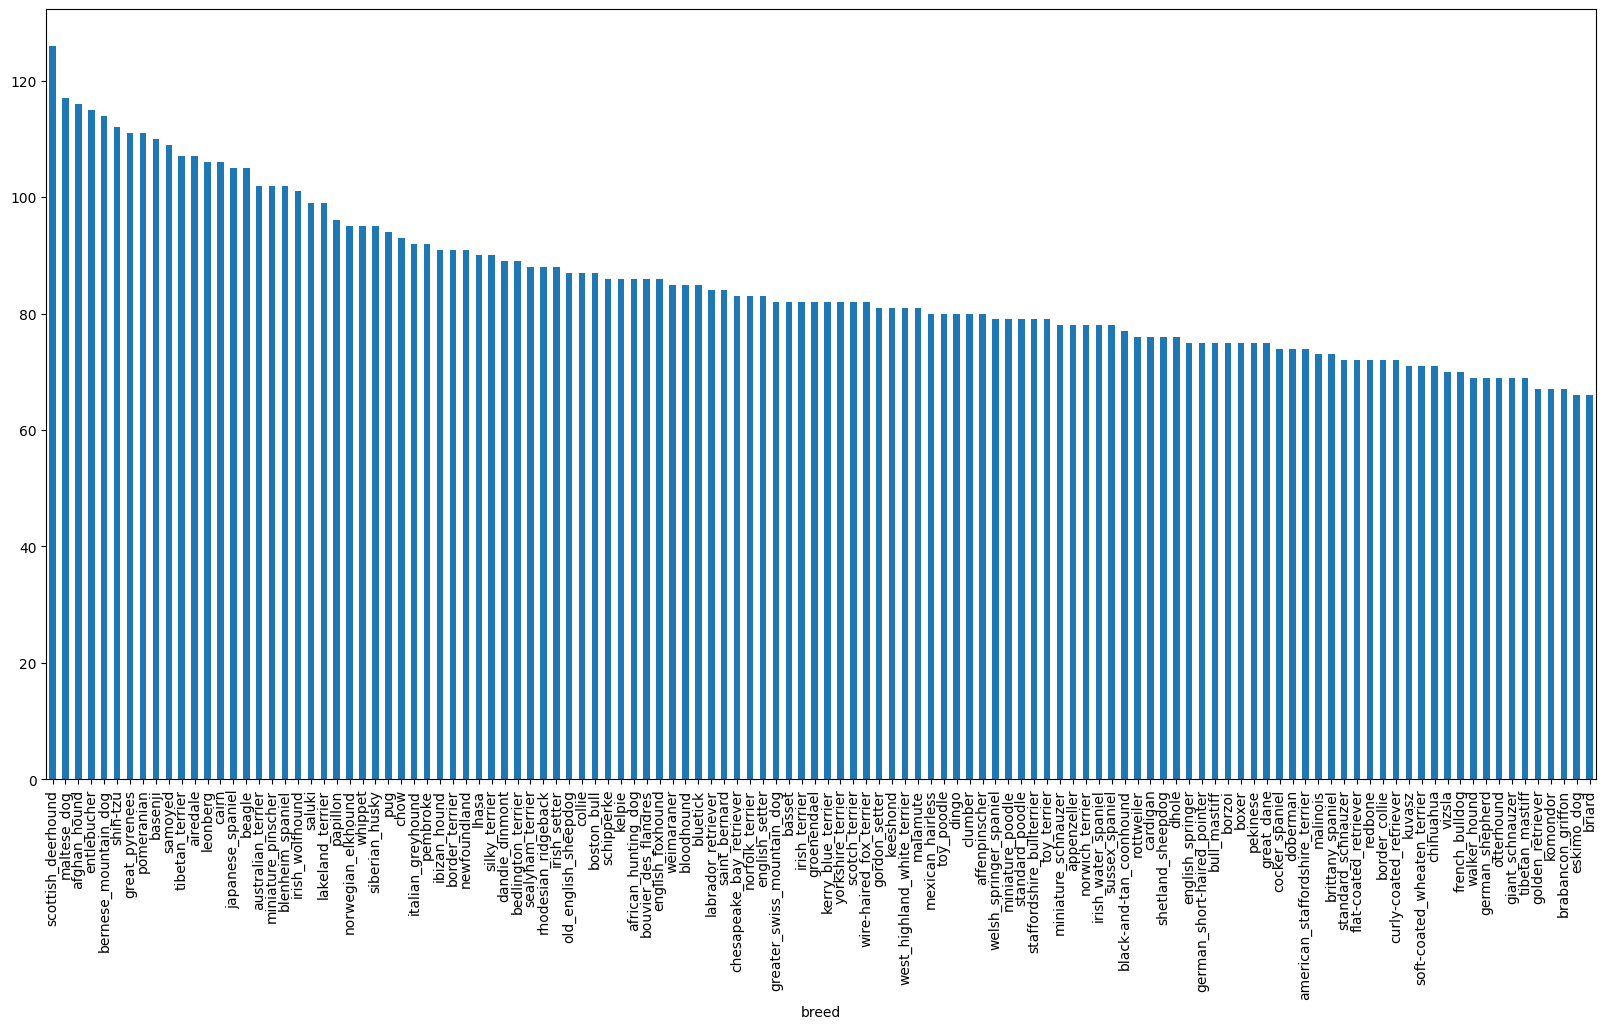

In [ ]:
labels_csv["breed"].value_counts().plot.bar(figsize=(20,10))

In [ ]:
labels_csv["breed"].value_counts().median()

82.0

In [ ]:
labels_csv["breed"].value_counts().mean()

np.float64(85.18333333333334)

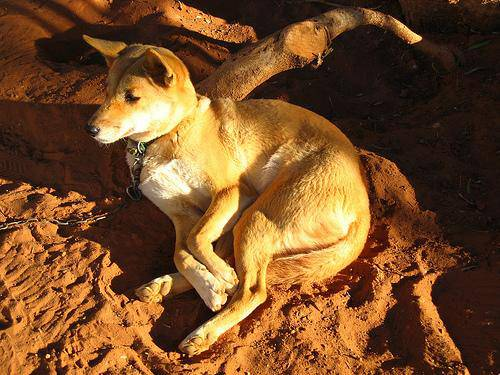

In [ ]:
# Lets view an image
from IPython.display import Image
Image("drive/MyDrive/DogVision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

### Getting images and their labels
Let's get a list of all our image file pathnames.

In [ ]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [ ]:
# create pathname from image ID's
filenames = ["drive/MyDrive/DogVision/train/"+   fname +".jpg" for fname in labels_csv["id"]  ]

filenames[:10]

['drive/MyDrive/DogVision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/DogVision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/DogVision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/DogVision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/DogVision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/DogVision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/DogVision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/DogVision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/DogVision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/DogVision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [ ]:
# check number of filenames matches the number of actual image files
len(filenames)

10222

In [ ]:
import os

os.listdir("drive/MyDrive/DogVision/train/")[:10]

['e5f8c5b22071d0a266d80e3f9edc1cd0.jpg',
 'e7af8f590b4fbdca0779f5e606ef91a1.jpg',
 'e0afc52cda56b96803e099a0b69fb173.jpg',
 'e4bb015a94aec342233058e7bf430704.jpg',
 'dfc12676704c8931010ff087e117d2f2.jpg',
 'e1cacd82bce4a66313debf5e883fa806.jpg',
 'e24af0affe6c7a51b3e8ed9c30b090b7.jpg',
 'deb5ab49dab71dea5d3a076f00eb4820.jpg',
 'e673bb6ca717b8dffe3b5ba35da07a83.jpg',
 'dcd8ee5311136967d14a2b4592963da1.jpg']

In [ ]:
# to check number of filenames matches the number of actual files


if len(os.listdir("drive/MyDrive/DogVision/train/")) == len(filenames):
  print("Filenames match actuall amount of filesss..proceed ")
else:
  print("Filenames do not match actual amount of files , check the targer directory")

Filenames match actuall amount of filesss..proceed 


In [ ]:
filenames[9000]

'drive/MyDrive/DogVision/train/e20e32bf114141e20a1af854ca4d0ecc.jpg'

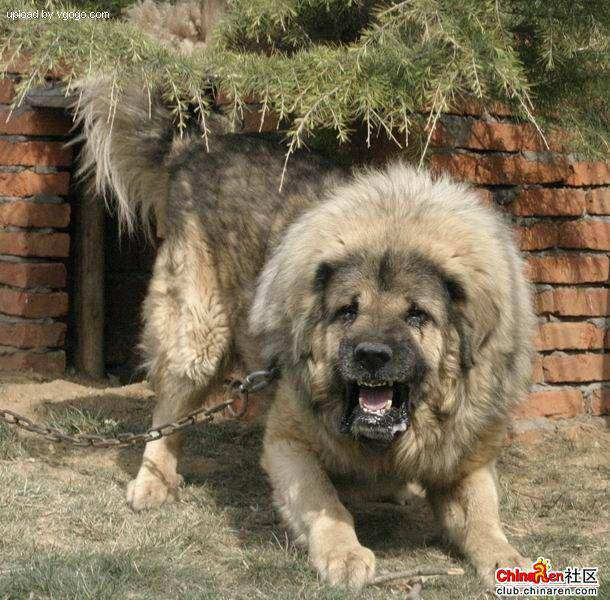

In [ ]:
# One more check

Image(filenames[9000])

In [ ]:
labels_csv["breed"][9000]

'tibetan_mastiff'

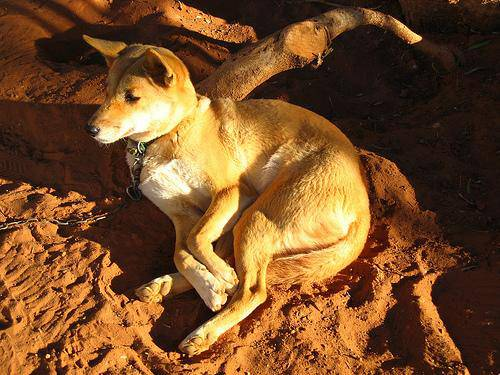

In [ ]:
Image(filenames[1])

In [ ]:
labels_csv["breed"][1]

'dingo'

Since we've now got our training image filepaths in a list, let's prepare our labels.

In [ ]:
import numpy as np
labels = labels_csv["breed"].to_numpy()
# labels = np.array(labels)   # does same thing as above
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [ ]:
len(labels)

10222

In [ ]:
# see if number of lables matches the number the number of filenames
if len(labels)==len(filenames):
  print("number of labels matches the number of filenames")
else:
  print("number of labels does not match the number of filenames")

number of labels matches the number of filenames


In [ ]:
# find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [ ]:
print(unique_breeds)

['affenpinscher' 'afghan_hound' 'african_hunting_dog' 'airedale'
 'american_staffordshire_terrier' 'appenzeller' 'australian_terrier'
 'basenji' 'basset' 'beagle' 'bedlington_terrier' 'bernese_mountain_dog'
 'black-and-tan_coonhound' 'blenheim_spaniel' 'bloodhound' 'bluetick'
 'border_collie' 'border_terrier' 'borzoi' 'boston_bull'
 'bouvier_des_flandres' 'boxer' 'brabancon_griffon' 'briard'
 'brittany_spaniel' 'bull_mastiff' 'cairn' 'cardigan'
 'chesapeake_bay_retriever' 'chihuahua' 'chow' 'clumber' 'cocker_spaniel'
 'collie' 'curly-coated_retriever' 'dandie_dinmont' 'dhole' 'dingo'
 'doberman' 'english_foxhound' 'english_setter' 'english_springer'
 'entlebucher' 'eskimo_dog' 'flat-coated_retriever' 'french_bulldog'
 'german_shepherd' 'german_short-haired_pointer' 'giant_schnauzer'
 'golden_retriever' 'gordon_setter' 'great_dane' 'great_pyrenees'
 'greater_swiss_mountain_dog' 'groenendael' 'ibizan_hound' 'irish_setter'
 'irish_terrier' 'irish_water_spaniel' 'irish_wolfhound'
 'italian

In [ ]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [ ]:
# Turn every label into boolean array

boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [ ]:
len(boolean_labels)

10222

In [ ]:
# Example : Turning boolean array into integers
print(labels[0])
print(np.where(unique_breeds == labels[0]))  # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) #there will be a 1 where the sample label occurs


boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [ ]:
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [ ]:
filenames[:10]

['drive/MyDrive/DogVision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/DogVision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/DogVision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/DogVision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/DogVision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/DogVision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/DogVision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/DogVision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/DogVision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/DogVision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

### Creating our own validation set
Since the dataset from kaggle doesn't come with a validation set , we're going to create our own.

In [ ]:
# setup x and y variables
X = filenames
Y = boolean_labels

In [ ]:
len(filenames),len(boolean_labels)

(10222, 10222)

We're going to start off experimenting with ~1000 images and increase as needed.

In [ ]:
# Set number of images to use for experimenting

NUM_IMAGES = 1000 # @param {type:"slider", min:10000, max:1000, step:1000}

In [ ]:
# lets split our data into train and validation sets
from sklearn.model_selection import train_test_split

# Split our data into training and validation of total size NUM_IMAGES
x_train, x_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  Y[:NUM_IMAGES],
                                                  test_size = 0.2,
                                                  random_state = 52)
len(x_train), len(y_train) , len(x_val), len(y_val)

(800, 800, 200, 200)

In [ ]:
# Lets have a geez at the training dara
x_train[:5] , y_train[:5]

(['drive/MyDrive/DogVision/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg',
  'drive/MyDrive/DogVision/train/1066d43c5f952120ec355bb56459228a.jpg',
  'drive/MyDrive/DogVision/train/00e9ed3fab1d2032603d1a90e557976f.jpg',
  'drive/MyDrive/DogVision/train/185dd9ac0589562442f553cf686783d4.jpg',
  'drive/MyDrive/DogVision/train/187a741ca8f22a04de67b60beb12987c.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False,  True, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False

## Preprocessing Images (Turning images into Tensors)

To preprocess our images into Tensors we're going to write a function which does a few things:
1. Take an image filepath as input
2. Use Tensorflow to read the file and save it to a variable , `image`
3. Turn our `image` (a jpg ) into Tensors
4. Resize the `image` to be a shape of (224,224)
5. Return the modified `image`



Before we do , lets see what importing an image looks like.


In [ ]:
 # Convert an image to numpy
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]],

       [[ 56, 104,  66],
        [ 58, 106,  68],
        [ 64, 112,  74],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 74, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  11],
        [  8,  14,  14],
        ...,
        [120, 113,  67],
        [126, 118,  71],
        [122, 114,  67]],

       [[  0,   3,   7],
        [  2,   7,  10],
        [  3,   9,   7],
        ...,
        [105,  98,  54],
        [112, 104,  58],
        [111, 103,  57]],

       [[ 16,  18,  30],
        [ 16,  19,  24],
        [ 15,  20,  14],
        ...,
        [101,  92,  51],
        [ 97,  88,  47],
        [120, 111,  70]]], dtype=uint8)
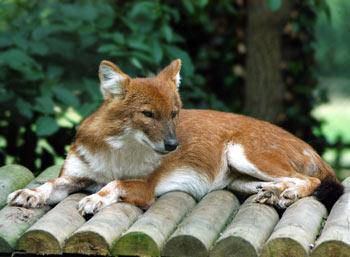

In [ ]:
image

In [ ]:
image.max(), image.min()

(np.uint8(255), np.uint8(0))

In [ ]:
image[:2]

array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)

In [ ]:
# Turn image into tensor
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)>

Now we,ve seen what an image looks like as a Tensor , Lets make a function to process them .

1. Take an image filepath as input
2. Use Tensorflow to read the file and save it to a variable , `image`
3. Turn our `image` (a jpg ) into Tensors
4. Normalize our image(convert colour channle values from 0-255 to 0-1)
5. Resize the `image` to be a shape of (224,224)
6. Return the modified `image`


In [ ]:

# define image size
IMG_SIZE = 224

# create a function for preprocessing images

def process_image(image_path, img_size=IMG_SIZE):
  """
  Takes an image file path and turn the image into tensor.
  """
  # Read an image file
  image = tf.io.read_file(image_path)

  # turn the jpeg image into numerical tensor with 3 colours channels (Red , Greed, Blue)
  image = tf.image.decode_jpeg(image, channels=3)

  # convert the colour channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)

  # Resize the image to our desired value (244,244)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image



## Truning our data into batches
why turn our data into batches ?
Lets say you are trying to process 10000+ images in one go.... they all might not fit into the memory.

so thats why we do about 32 image(this is batch size) at a time (we can manually adjust the batch size if need to be ).

In order to use Tensorflow affectively , we need our data in the form of tensor tuples which looks like this:
`(image,label)`.

In [ ]:
# create a simple function to return a tuple (image,label)

def get_image_label(image_path, label):


  image = process_image(image_path)
  return image, label

In [ ]:
#  demo of the above
(process_image(X[42]), tf.constant(Y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

In [ ]:
get_image_label(X[42], Y[42])

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now we've got a way to turn our data into tuples of tensors in the form:`(image ,label)` , lets make a function to turn all our data (x and y ) into batches



In [ ]:
# define the batch size
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X , y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of our data out of images (x) and labels (y) pairs.
  data if it's trainig data but don't shuffle if its validation data.
  Also accept test data as input (no labels).
  """

  # if the data is test dataset , we probably dont have labels
  if test_data:
    print("Creating test data batches....")
    data =  tf.data.Dataset.from_tensor_slices((tf.constant(X)))
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If the data is a valid dataset , we dont need to shuffle it
  elif valid_data :
    print("Creating valid data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Creating training data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(X))

    # Create (image. label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the traing data into batches
    data_batch = data.batch(BATCH_SIZE)

    return data_batch






In [ ]:
# create training and validation data batches
train_data = create_data_batches(x_train, y_train)
val_data = create_data_batches(x_val, y_val, valid_data=True)

Creating training data batches...
Creating valid data batches...


In [ ]:
# check out different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing Data Batches
Our data is now in batches , however, these can be a little hard to understand/comprehend, let's visualize them!!

In [ ]:
import matplotlib.pyplot as plt

# create a function for viewing images in a data batches
def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(10,10))

  # Loop through 25 (for displaying 25 images)
  for i in range(25):

    # create subplots (5 rows, 5 columns)
    ax=plt.subplot(5,5,i+1)
    # display an image
    plt.imshow(images[i])
    # Add the image label as title
    plt.title(unique_breeds[labels[i].argmax()])
    #turn the gridlines off
    plt.axis("off")


In [ ]:
train_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

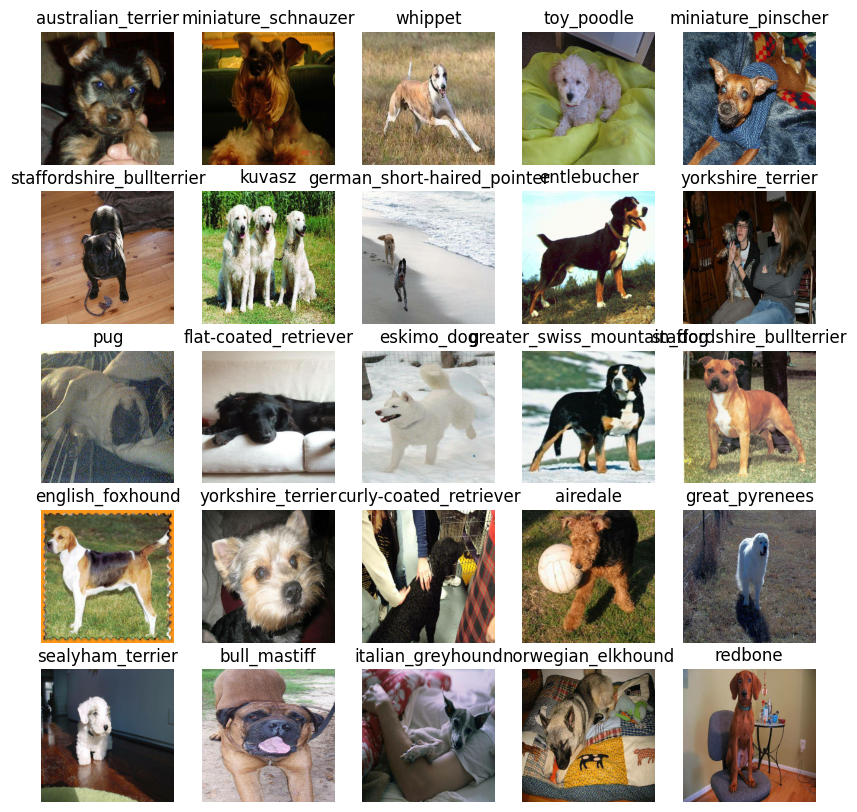

In [ ]:
# now lets visualize the data
train_images, train_labels= next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

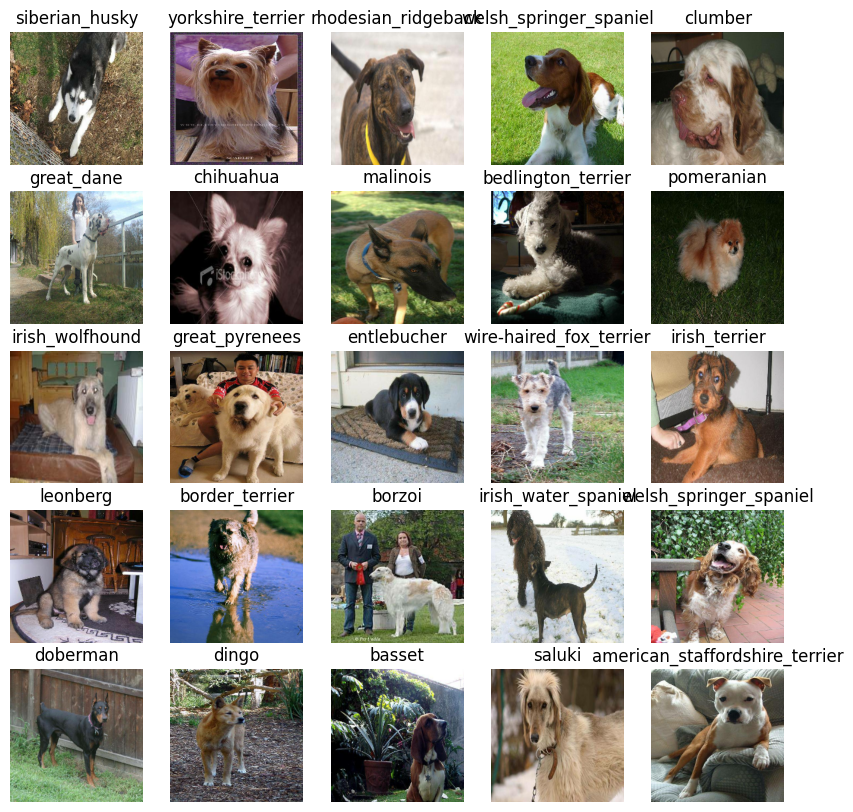

In [ ]:
#  now lets visualize our validation set
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images,val_labels)

## Building a model

Befor we build a model, there are few thing we need to define:
* The input shape(Our image shape, in the form of Tensors) to our model.
* The output shape(image lables, in the form of tensors) of our model.
* The URL of the model we want to use .

In [ ]:
IMG_SIZE

224

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

# setup input shape to the model
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3) #height, width, colour channels

# setupu the output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# setup model URL from TensorFlow HUb (using a feature vector model)
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/4"

Now we've got our inputs , outputs and model ready to go.
Let's put them together into a Keras deep learning model !!!


Knowing this , lets create a function with:
* Takes the input shape, output shape and the model we've chosen as parameters.
* Defines the layers in keras model in sequential fashion (do this first, then this, then that).
* Compiles the model(says it should be evaluated and improved).
* Builds the model (tells the model the input shape it'll be getting).
* Return the model.


In [ ]:
# Create a function which builds a keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  #setup the model layers
  model = tf.keras.Sequential([
      hub.KerasLayer(MODEL_URL), #layer 1 (input layer)
      tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                            activation="softmax") # layer 2 (output layer)
      ])

  #compile the model
  model.compile(
      loss = tf.keras.losses.CategoricalCrossentropy(),
      optimizer = tf.keras.optimizers.Adam(),
      metrics = ["accuracy"]
  )

  # build the model
  model.build(INPUT_SHAPE)

  return model


In [ ]:
model = create_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/4


ValueError: Only instances of `keras.Layer` can be added to a Sequential model. Received: <tensorflow_hub.keras_layer.KerasLayer object at 0x7e9a2c698680> (of type <class 'tensorflow_hub.keras_layer.KerasLayer'>)